<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/FT_Transformer(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# =============================================================================
# STEP 1: Import Libraries and Set Random Seeds
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported and random seeds set for reproducibility")


Libraries imported and random seeds set for reproducibility


In [50]:

# =============================================================================
# STEP 2: Define Custom Dataset Class
# =============================================================================

class CropDataset(Dataset):
    """Custom Dataset for crop production data"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

print("Custom Dataset class defined")


Custom Dataset class defined


In [51]:

# =============================================================================
# STEP 3: Define F1-Transformer Model Architecture
# =============================================================================

class F1TransformerModel(nn.Module):
    """F1-Transformer model for crop production classification"""
    def __init__(self, input_dim, num_classes=3, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super(F1TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding (simple learned embedding)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)  # [batch_size, d_model]

        # Add batch and sequence dimensions for transformer
        x = x.unsqueeze(1)  # [batch_size, 1, d_model]

        # Add positional encoding
        x = x + self.pos_embedding

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, 1, d_model]

        # Remove sequence dimension and classify
        x = x.squeeze(1)  # [batch_size, d_model]
        output = self.classifier(x)

        return output

print("F1-Transformer model architecture defined")


F1-Transformer model architecture defined


In [52]:

# =============================================================================
# STEP 4: Define Helper Functions
# =============================================================================

def create_labels(production_values, quantiles):
    """Create 3-level labels based on quantiles"""
    labels = []
    for val in production_values:
        if val <= quantiles[0]:
            labels.append(0)  # Low
        elif val <= quantiles[1]:
            labels.append(1)  # Medium
        else:
            labels.append(2)  # High
    return np.array(labels)

def calculate_metrics(y_true, y_pred):
    """Calculate all classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

def plot_confusion_matrix(y_true, y_pred, title, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores):
    """Plot training history with enhanced visualization"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot F1 scores
    ax3.plot(train_f1_scores, label='Training F1 Score', color='blue', linewidth=2)
    ax3.plot(val_f1_scores, label='Validation F1 Score', color='red', linewidth=2)
    ax3.set_title('Model F1 Score (Macro)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot comparison of all metrics
    epochs = range(1, len(train_losses) + 1)
    ax4.plot(epochs, np.array(train_accuracies)/100, label='Train Acc', color='blue', alpha=0.7)
    ax4.plot(epochs, np.array(val_accuracies)/100, label='Val Acc', color='red', alpha=0.7)
    ax4.plot(epochs, train_f1_scores, label='Train F1', color='blue', linestyle='--')
    ax4.plot(epochs, val_f1_scores, label='Val F1', color='red', linestyle='--')
    ax4.set_title('Normalized Metrics Comparison', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, data_loader, device='cpu'):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

print("Helper functions defined")


Helper functions defined


In [53]:

# =============================================================================
# STEP 5: Load and Preprocess Data
# =============================================================================

print("=== Step 5: Loading and Preprocessing Data ===")

# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Handle missing values
for df in [train_df, val_df, test_df]:
    df.fillna(df.mean(numeric_only=True), inplace=True)

print("Missing values handled")


=== Step 5: Loading and Preprocessing Data ===
Train set shape: (3942, 84)
Validation set shape: (845, 84)
Test set shape: (845, 84)
Missing values handled


In [54]:

# =============================================================================
# STEP 6: Create Labels Based on Production Quantiles
# =============================================================================

print("=== Step 6: Creating Labels Based on Production Quantiles ===")

# Create quantile-based labels for production (3 classes)
production_col = 'Production (M.Ton)'

# Calculate quantiles from training data only - using tertiles for 3 classes
quantiles = train_df[production_col].quantile([0.33, 0.67]).values

# Create labels
train_labels = create_labels(train_df[production_col].values, quantiles)
val_labels = create_labels(val_df[production_col].values, quantiles)
test_labels = create_labels(test_df[production_col].values, quantiles)

print(f"Label distribution in training set:")
unique, counts = np.unique(train_labels, return_counts=True)
label_names = ['Low', 'Medium', 'High']
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"  {label_names[label]}: {count} ({count/len(train_labels)*100:.1f}%)")

print(f"\nQuantile thresholds:")
print(f"  Low: ≤ {quantiles[0]:.3f} M.Ton")
print(f"  Medium: {quantiles[0]:.3f} - {quantiles[1]:.3f} M.Ton")
print(f"  High: > {quantiles[1]:.3f} M.Ton")


=== Step 6: Creating Labels Based on Production Quantiles ===
Label distribution in training set:
  Low: 1301 (33.0%)
  Medium: 1340 (34.0%)
  High: 1301 (33.0%)

Quantile thresholds:
  Low: ≤ 1071.556 M.Ton
  Medium: 1071.556 - 4035.910 M.Ton
  High: > 4035.910 M.Ton


In [55]:

# =============================================================================
# STEP 7: Prepare Features and Scale Data
# =============================================================================

print("=== Step 7: Preparing Features and Scaling Data ===")

# Remove target column from features
feature_cols = [col for col in train_df.columns if col != production_col]

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Feature dimensions: {X_train_scaled.shape[1]}")
print("Data scaling completed")


=== Step 7: Preparing Features and Scaling Data ===
Feature dimensions: 83
Data scaling completed


In [56]:

# =============================================================================
# STEP 8: Create PyTorch Datasets and DataLoaders
# =============================================================================

print("=== Step 8: Creating PyTorch Datasets and DataLoaders ===")

# Create datasets
train_dataset = CropDataset(X_train_scaled, train_labels)
val_dataset = CropDataset(X_val_scaled, val_labels)
test_dataset = CropDataset(X_test_scaled, test_labels)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


=== Step 8: Creating PyTorch Datasets and DataLoaders ===
DataLoaders created with batch size: 32
Training batches: 124
Validation batches: 27
Test batches: 27


In [57]:
# =============================================================================
# STEP 9: Initialize Model and Setup Training
# =============================================================================

print("=== Step 9: Initializing Model and Setup ===")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
input_dim = X_train_scaled.shape[1]
model = F1TransformerModel(input_dim=input_dim, num_classes=3).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Setup training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

print("Training setup completed")


=== Step 9: Initializing Model and Setup ===
Using device: cpu
Model parameters: 614,403
Trainable parameters: 614,403
Training setup completed


In [58]:


# =============================================================================
# STEP 10: Training Loop
# =============================================================================

print("=== Step 10: Training the Model ===")

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

best_val_f1 = 0
best_model_state = None

print(f"Training model for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_true = []

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

        train_predictions.extend(predicted.cpu().numpy())
        train_true.extend(batch_labels.cpu().numpy())

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_true = []

    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_labels.size(0)
            val_correct += (predicted == batch_labels).sum().item()

            val_predictions.extend(predicted.cpu().numpy())
            val_true.extend(batch_labels.cpu().numpy())

    # Calculate metrics
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    train_f1_macro = f1_score(train_true, train_predictions, average='macro')
    val_f1_macro = f1_score(val_true, val_predictions, average='macro')

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1_macro)
    val_f1_scores.append(val_f1_macro)

    # Save best model based on macro F1 score
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        best_model_state = model.state_dict().copy()

    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1_macro:.4f}')
        print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1_macro:.4f}')

# Load best model
model.load_state_dict(best_model_state)
print(f'Training completed! Best validation macro F1 score: {best_val_f1:.4f}')


=== Step 10: Training the Model ===
Training model for 50 epochs...
Epoch [10/50]
  Train Loss: 0.3503, Train Acc: 86.68%, Train F1: 0.8673
  Val Loss: 0.3858, Val Acc: 85.44%, Val F1: 0.8555
Epoch [20/50]
  Train Loss: 0.2660, Train Acc: 89.83%, Train F1: 0.8985
  Val Loss: 0.3339, Val Acc: 87.69%, Val F1: 0.8779
Epoch [30/50]
  Train Loss: 0.1742, Train Acc: 93.30%, Train F1: 0.9330
  Val Loss: 0.2785, Val Acc: 90.89%, Val F1: 0.9091
Epoch [40/50]
  Train Loss: 0.1714, Train Acc: 93.35%, Train F1: 0.9337
  Val Loss: 0.2968, Val Acc: 90.30%, Val F1: 0.9036
Epoch [50/50]
  Train Loss: 0.1149, Train Acc: 95.51%, Train F1: 0.9552
  Val Loss: 0.3096, Val Acc: 90.53%, Val F1: 0.9056
Training completed! Best validation macro F1 score: 0.9178


=== Step 11: Plotting Training History ===


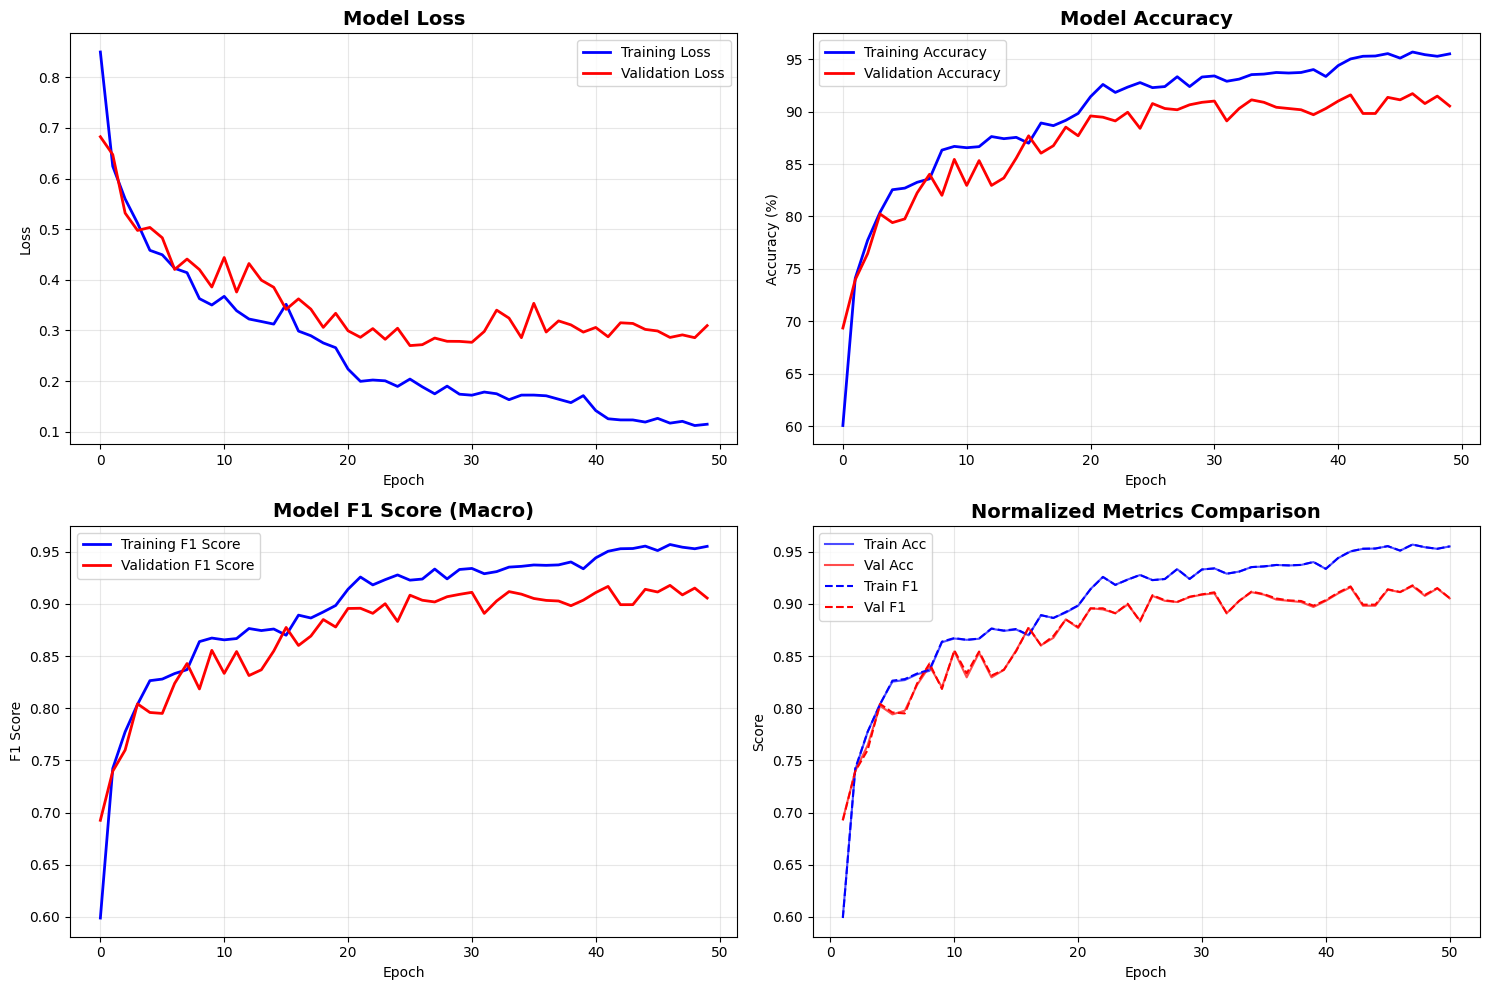

In [59]:
# =============================================================================
# STEP 11: Plot Training History
# =============================================================================

print("=== Step 11: Plotting Training History ===")

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores)


In [60]:


# =============================================================================
# STEP 12: Evaluate on Validation Set
# =============================================================================

print("=== Step 12: Validation Set Evaluation ===")

val_pred, val_true = evaluate_model(model, val_loader, device)
val_metrics = calculate_metrics(val_true, val_pred)

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")


=== Step 12: Validation Set Evaluation ===
Validation Metrics:
  Accuracy: 0.9053
  Precision (Macro): 0.9052
  Recall (Macro): 0.9073
  F1 Score (Macro): 0.9056
  F1 Score (Weighted): 0.9046


In [61]:

# =============================================================================
# STEP 13: Evaluate on Test Set
# =============================================================================

print("=== Step 13: Test Set Evaluation ===")

test_pred, test_true = evaluate_model(model, test_loader, device)
test_metrics = calculate_metrics(test_true, test_pred)

print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")


=== Step 13: Test Set Evaluation ===
Test Metrics:
  Accuracy: 0.9302
  Precision (Macro): 0.9297
  Recall (Macro): 0.9301
  F1 Score (Macro): 0.9297
  F1 Score (Weighted): 0.9300


=== Step 14: Plotting Confusion Matrices ===


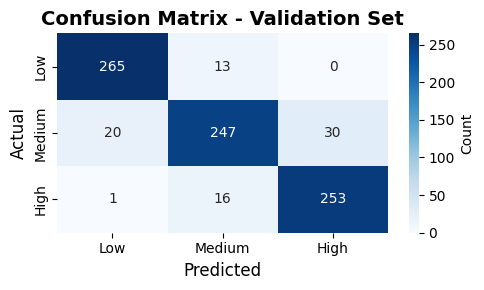

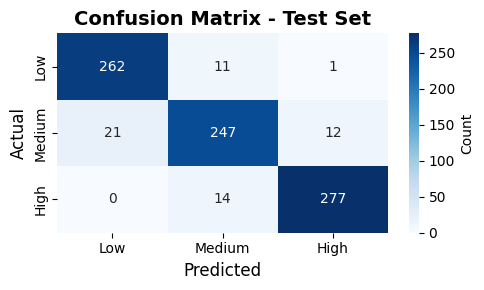

In [62]:

# =============================================================================
# STEP 14: Plot Confusion Matrices
# =============================================================================

print("=== Step 14: Plotting Confusion Matrices ===")

class_names = ['Low', 'Medium', 'High']

plot_confusion_matrix(val_true, val_pred, "Validation Set", class_names)
plot_confusion_matrix(test_true, test_pred, "Test Set", class_names)


In [63]:

# =============================================================================
# STEP 15: Generate Detailed Reports
# =============================================================================

print("=== Step 15: Detailed Classification Reports ===")

print("\n=== Detailed Classification Report - Validation Set ===")
print(classification_report(val_true, val_pred, target_names=class_names))

print("\n=== Detailed Classification Report - Test Set ===")
print(classification_report(test_true, test_pred, target_names=class_names))


=== Step 15: Detailed Classification Reports ===

=== Detailed Classification Report - Validation Set ===
              precision    recall  f1-score   support

         Low       0.93      0.95      0.94       278
      Medium       0.89      0.83      0.86       297
        High       0.89      0.94      0.92       270

    accuracy                           0.91       845
   macro avg       0.91      0.91      0.91       845
weighted avg       0.91      0.91      0.90       845


=== Detailed Classification Report - Test Set ===
              precision    recall  f1-score   support

         Low       0.93      0.96      0.94       274
      Medium       0.91      0.88      0.89       280
        High       0.96      0.95      0.95       291

    accuracy                           0.93       845
   macro avg       0.93      0.93      0.93       845
weighted avg       0.93      0.93      0.93       845



In [64]:

# =============================================================================
# STEP 16: Final Results Summary
# =============================================================================

print("=== Step 16: Final Results Summary ===")

# Summary table
results_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_metrics['Accuracy'], test_metrics['Accuracy']],
    'Precision (Macro)': [val_metrics['Precision (Macro)'], test_metrics['Precision (Macro)']],
    'Recall (Macro)': [val_metrics['Recall (Macro)'], test_metrics['Recall (Macro)']],
    'F1 Score (Macro)': [val_metrics['F1 Score (Macro)'], test_metrics['F1 Score (Macro)']],
    'F1 Score (Weighted)': [val_metrics['F1 Score (Weighted)'], test_metrics['F1 Score (Weighted)']]
})

print(results_df.round(4).to_string(index=False))

# Class-wise performance analysis
print("\n=== Class-wise Performance Analysis ===")
print("Validation Set:")
val_report = classification_report(val_true, val_pred, target_names=class_names, output_dict=True)
for class_name in class_names:
    metrics = val_report[class_name]
    print(f"  {class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

print("Test Set:")
test_report = classification_report(test_true, test_pred, target_names=class_names, output_dict=True)
for class_name in class_names:
    metrics = test_report[class_name]
    print(f"  {class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

print("\n=== Training and Evaluation Complete ===")
print("All steps executed successfully!")
print(f"Final model saved with best validation F1 score: {best_val_f1:.4f}")
print(f"Production quantile thresholds: {quantiles}")


=== Step 16: Final Results Summary ===
   Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  F1 Score (Weighted)
Validation    0.9053             0.9052          0.9073            0.9056               0.9046
      Test    0.9302             0.9297          0.9301            0.9297               0.9300

=== Class-wise Performance Analysis ===
Validation Set:
  Low: Precision=0.927, Recall=0.953, F1=0.940
  Medium: Precision=0.895, Recall=0.832, F1=0.862
  High: Precision=0.894, Recall=0.937, F1=0.915
Test Set:
  Low: Precision=0.926, Recall=0.956, F1=0.941
  Medium: Precision=0.908, Recall=0.882, F1=0.895
  High: Precision=0.955, Recall=0.952, F1=0.954

=== Training and Evaluation Complete ===
All steps executed successfully!
Final model saved with best validation F1 score: 0.9178
Production quantile thresholds: [1071.5565 4035.9099]
